# Compare all the tree-guided MTL models on the iPCs data produced by Kathrin

In the following I load every individual RData pbject that the TGGLasso script generated. And then assign separate names to the loaded variables, reflecting which setup they correspond to. Then, by having these, I compute the correlation (pearson and spearman) between the measured and predicted values of single-cell gene expression.

If you don't wanna bother about the deatiled coding, you can simply scroll down to the very end, where the plot for this comparison is created as well as the conclusion points.

## Load the model trained on dynamic features with imputed expression data

In [1]:
load("../scMTL_StemNet_imputed_dynamic_TGGLasso.RData")
print(ls())

[1] "best.lambda" "lambdas"     "mst"         "partition"   "pred.acc"   
[6] "TGL.model"  


In [2]:
dyn_imp_TGL_model <- TGL.model
dyn_imp_partition <- partition

## Load the model trained on dynamic features with not-imputed expression data

In [3]:
load("../scMTL_StemNet_notImputed_dynamic_TGGLasso.RData")
print(ls())

[1] "best.lambda"       "dyn_imp_partition" "dyn_imp_TGL_model"
[4] "lambdas"           "mst"               "partition"        
[7] "pred.acc"          "TGL.model"        


In [4]:
dyn_not_imp_TGL_model <- TGL.model
dyn_not_imp_partition <- partition

## Load the model trained on epigenetic features with imputed expression data

In [5]:
load("../scMTL_StemNet_imputed_epigenetic_TGGLasso.RData")
print(ls())

 [1] "best.lambda"           "dyn_imp_partition"     "dyn_imp_TGL_model"    
 [4] "dyn_not_imp_partition" "dyn_not_imp_TGL_model" "lambdas"              
 [7] "mst"                   "partition"             "pred.acc"             
[10] "TGL.model"            


In [6]:
epi_imp_TGL_model <- TGL.model
epi_imp_partition <- partition

## Load the model trained on epigenetic features with not-imputed expression data

In [7]:
load("../scMTL_StemNet_notImputed_epigenetic_TGGLasso.RData")
print(ls())

 [1] "best.lambda"           "dyn_imp_partition"     "dyn_imp_TGL_model"    
 [4] "dyn_not_imp_partition" "dyn_not_imp_TGL_model" "epi_imp_partition"    
 [7] "epi_imp_TGL_model"     "lambdas"               "mst"                  
[10] "partition"             "pred.acc"              "TGL.model"            


In [8]:
epi_not_imp_TGL_model <- TGL.model
epi_not_imp_partition <- partition

## Load the model trained on static features with imputed expression data

In [9]:
load("../scMTL_StemNet_imputed_static_TGGLasso.RData")
print(ls())

 [1] "best.lambda"           "dyn_imp_partition"     "dyn_imp_TGL_model"    
 [4] "dyn_not_imp_partition" "dyn_not_imp_TGL_model" "epi_imp_partition"    
 [7] "epi_imp_TGL_model"     "epi_not_imp_partition" "epi_not_imp_TGL_model"
[10] "lambdas"               "mst"                   "partition"            
[13] "pred.acc"              "TGL.model"            


In [10]:
sta_imp_TGL_model <- TGL.model
sta_imp_partition <- partition

## Load the model trained on static features with not-imputed expression data

In [11]:
load("../scMTL_StemNet_notImputed_static_TGGLasso.RData")
print(ls())

 [1] "best.lambda"           "dyn_imp_partition"     "dyn_imp_TGL_model"    
 [4] "dyn_not_imp_partition" "dyn_not_imp_TGL_model" "epi_imp_partition"    
 [7] "epi_imp_TGL_model"     "epi_not_imp_partition" "epi_not_imp_TGL_model"
[10] "lambdas"               "mst"                   "partition"            
[13] "pred.acc"              "sta_imp_partition"     "sta_imp_TGL_model"    
[16] "TGL.model"            


In [12]:
sta_not_imp_TGL_model <- TGL.model
sta_not_imp_partition <- partition

## Normalize the partitioned data
The stored partitioned data in the above RData object is log-transformed. but not normalized. In order to proceed with the downstream analysis, it's easier to normalize them in the same way they were done before model fitting.

In [13]:
preprocess_partition <- function(partition){
    x.train <- scale(partition$train$x)
    y.train <- scale(partition$train$y)


    x.test <- scale(partition$test$x, center= colMeans(partition$train$x),
                    scale= apply(partition$train$x, 2, FUN= sd))
    y.test <- scale(partition$test$y, center= colMeans(partition$train$y),
                    scale= apply(partition$train$y, 2, FUN= sd))
    return(list(x.train= x.train, y.train= y.train, x.test= x.test, y.test= y.test))
}

In [14]:
dyn_imp_partition <- preprocess_partition(dyn_imp_partition)
dyn_not_imp_partition <- preprocess_partition(dyn_not_imp_partition)
epi_imp_partition <- preprocess_partition(epi_imp_partition)
epi_not_imp_partition <- preprocess_partition(epi_not_imp_partition)
sta_imp_partition <- preprocess_partition(sta_imp_partition)
sta_not_imp_partition <- preprocess_partition(sta_not_imp_partition)

## Train and test dimenstion

In [15]:
print("dynamic")
print(paste("train: ", paste(dim(dyn_imp_partition$x.train), collapse = "x")))
print(paste("test", paste(dim(dyn_imp_partition$x.test), collapse = "x")))

print("epigenetic")
print(paste("train: ", paste(dim(epi_imp_partition$x.train), collapse = "x")))
print(paste("test", paste(dim(epi_imp_partition$x.test), collapse = "x")))

[1] "dynamic"
[1] "train:  8512x123"
[1] "test 5676x123"
[1] "epigenetic"
[1] "train:  2896x729"
[1] "test 1931x729"



## Cell names

In [16]:
head(colnames(epi_imp_partition$y.train))

[1] "HLC_CEL_c11_R1" "HLC_CEL_c17_R1" "HLC_CEL_c25_R1" "HLC_CEL_c35_R1"
[5] "HLC_CEL_c41_R1" "HLC_CEL_c42_R1"

## Compute the predictions on training and test data

In [17]:
get_preds <- function(partition, TGL.model){
    pred.train <- cbind(1, partition$x.train) %*% rbind(TGL.model$intercept, TGL.model$B)
    pred.test <- cbind(1, partition$x.test) %*% rbind(TGL.model$intercept, TGL.model$B)
    return(list(pred.train= pred.train, pred.test= pred.test))
}

In [18]:
dyn_imp_preds <- get_preds(dyn_imp_partition, dyn_imp_TGL_model)
dyn_not_imp_preds <- get_preds(dyn_not_imp_partition, dyn_not_imp_TGL_model)

epi_imp_preds <- get_preds(epi_imp_partition, epi_imp_TGL_model)
epi_not_imp_preds <- get_preds(epi_not_imp_partition, epi_not_imp_TGL_model)

sta_imp_preds <- get_preds(sta_imp_partition, sta_imp_TGL_model)
sta_not_imp_preds <- get_preds(sta_not_imp_partition, sta_not_imp_TGL_model)

### Plot the scatter plots for some random cells (training data)

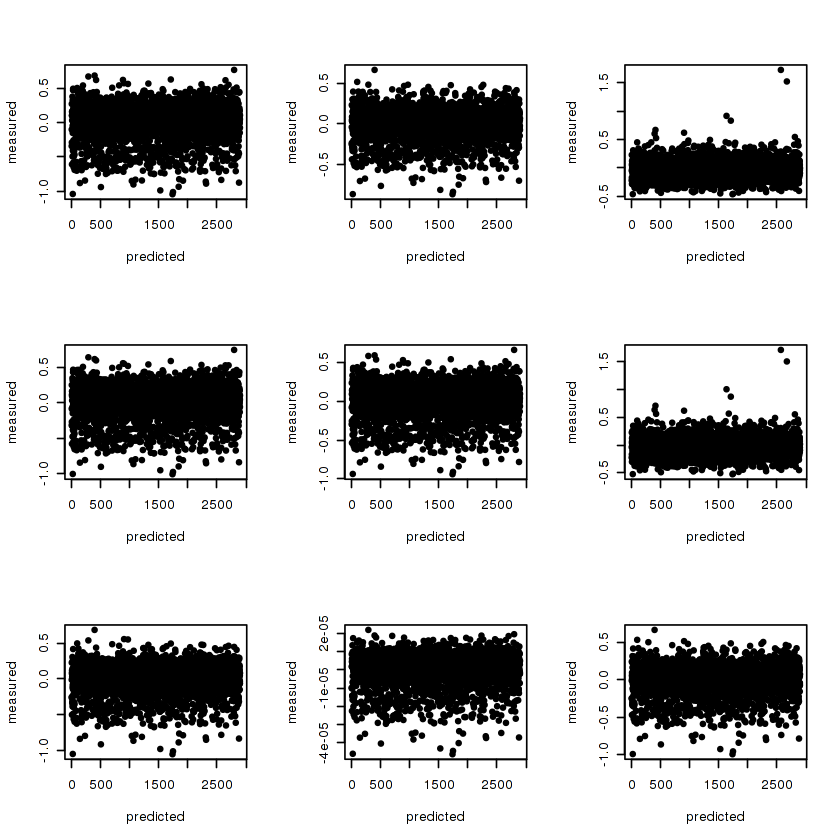

In [19]:
n <- 9
par(mfrow = c(sqrt(n), sqrt(n)))

random.idx <- sample(ncol(epi_imp_preds$pred.train))[seq(n)]
for(i in seq(n))
    plot(epi_imp_preds$pred.train[, random.idx[i]], epi_imp_preds$y.train[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

### Plot the scatter plots for some random cells (test data)

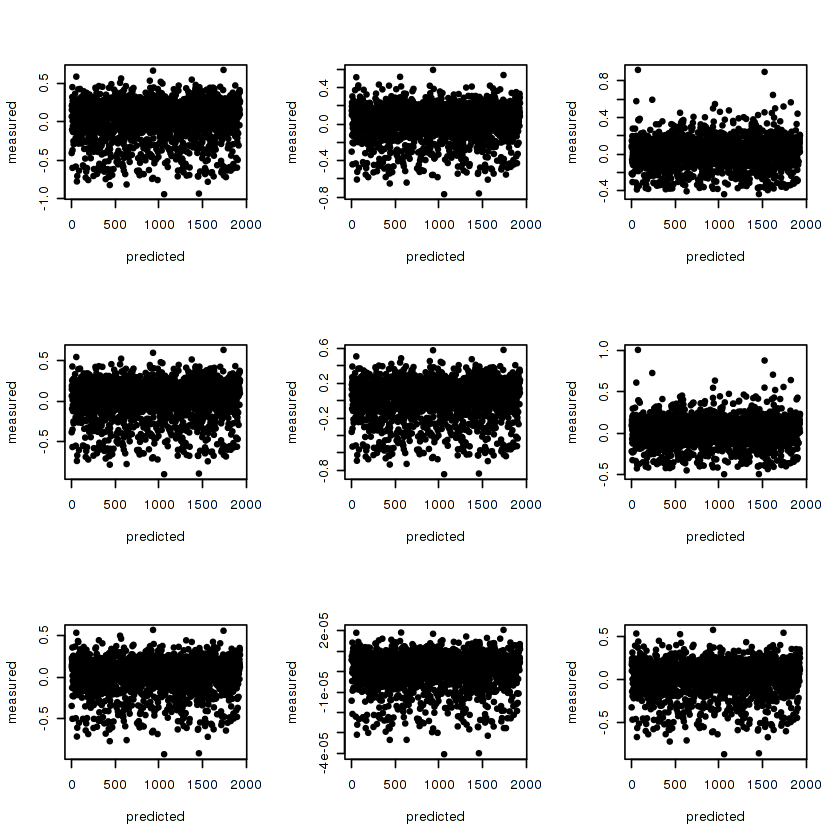

In [20]:
par(mfrow = c(sqrt(n), sqrt(n)))

#random.idx <- sample(ncol(pred.test))[seq(n)]
for(i in seq(n))
    plot(epi_imp_preds$pred.test[, random.idx[i]], epi_imp_preds$y.test[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

## Compute the correlations between predicted and actual measurements of gene expression

In [21]:
options(warn= -1)
get_pred_cors <- function(preds, partition){
    # Train
    ## Method= Pearson
    cors.train.p <- sapply(seq(ncol(preds$pred.train)), function(i)
        cor(preds$pred.train[, i], partition$y.train[, i], method= "pearson"))

    ## Method= Spearman
    cors.train.s <- sapply(seq(ncol(preds$pred.train)), function(i)
        cor(preds$pred.train[, i], partition$y.train[, i], method= "spearman"))

    # Test
    ## Method= Pearson
    cors.test.p <- sapply(seq(ncol(preds$pred.test)), function(i)
        cor(preds$pred.test[, i], partition$y.test[, i], method= "pearson"))

    ## Method= Spearman
    cors.test.s <- sapply(seq(ncol(preds$pred.test)), function(i)
        cor(preds$pred.test[, i], partition$y.test[, i], method= "spearman"))
                          
    return(list(cors.train.p= cors.train.p, cors.train.s= cors.train.s, cors.test.p= cors.test.p, cors.test.s= cors.test.s))
}

In [22]:
dyn_imp_cors <- get_pred_cors(dyn_imp_preds, dyn_imp_partition)
dyn_not_imp_cors <- get_pred_cors(dyn_not_imp_preds, dyn_not_imp_partition)

epi_imp_cors <- get_pred_cors(epi_imp_preds, epi_imp_partition)
epi_not_imp_cors <- get_pred_cors(epi_not_imp_preds, epi_not_imp_partition)

sta_imp_cors <- get_pred_cors(sta_imp_preds, sta_imp_partition)
sta_not_imp_cors <- get_pred_cors(sta_not_imp_preds, sta_not_imp_partition)

In [23]:
get_cor_df <- function(cors, feature_type, imputed){
    df <- data.frame(val= cors$cors.test.p, feature= feature_type, imputation_status= imputed,
                     cor_method= "Pearson", data_partition= "test")
    df <- rbind(df, data.frame(val= cors$cors.test.s, feature= feature_type, imputation_status= imputed,
                     cor_method= "Spearman", data_partition= "test"))
    df <- rbind(df, data.frame(val= cors$cors.train.p, feature= feature_type, imputation_status= imputed,
                     cor_method= "Pearson", data_partition= "train"))
    df <- rbind(df, data.frame(val= cors$cors.train.s, feature= feature_type, imputation_status= imputed,
                     cor_method= "Spearman", data_partition= "train"))
    return(df)
}

In [24]:
dyn_imp_df <- get_cor_df(dyn_imp_cors, "dynamic", "imputed")
dyn_not_imp_df <- get_cor_df(dyn_not_imp_cors, "dynamic", "notImputed")

epi_imp_df <- get_cor_df(epi_imp_cors, "epigenetic", "imputed")
epi_not_imp_df <- get_cor_df(epi_not_imp_cors, "epigenetic", "notImputed")

sta_imp_df <- get_cor_df(sta_imp_cors, "static", "imputed")
sta_not_imp_df <- get_cor_df(sta_not_imp_cors, "static", "notImputed")

## bind all dataframes together
df <- rbind(dyn_imp_df, dyn_not_imp_df, epi_imp_df, epi_not_imp_df, sta_imp_df, sta_not_imp_df)
head(df)

val,feature,imputation_status,cor_method,data_partition
0.4058099,dynamic,imputed,Pearson,test
0.4125152,dynamic,imputed,Pearson,test
0.4023380,dynamic,imputed,Pearson,test
0.4217069,dynamic,imputed,Pearson,test
0.3952114,dynamic,imputed,Pearson,test
0.4039255,dynamic,imputed,Pearson,test


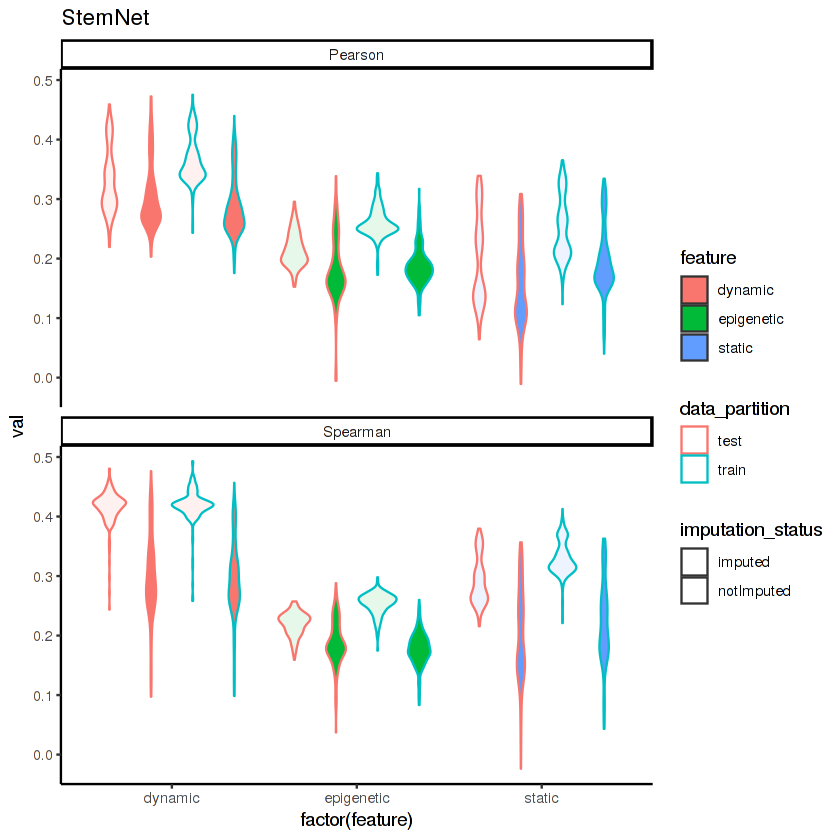

In [26]:
library(ggplot2)
ggplot(df, aes(factor(feature), val)) + 
geom_violin(aes(fill= feature, color= data_partition, alpha= imputation_status)) + 
ggtitle("StemNet") + facet_wrap("cor_method", ncol= 1) + 
theme_classic()


# Conclusion
* imputation (fainted color), overall, helped the prediction task, (the lowest end of the violin plots correspond to the notImputed case, shown in darker colors)
* dynamic features result in the best performance over all other two feature setups
* Then it comes the static features, which interestingly show a better correlation on the **train** data of the notImputed case. However, on the test data the imputed ones perform better.
* the epigenetic features also perform reasonbaly, with median correlation of around 0.25 on the test data. But, I think  the expectation was to observe better results than the static features. Here, the higher violin of the imputed train data indicates the possibility of overtraining. So, this case is interesting to be further investigated.
------
* I'm interested in seeing how much we can improve our predictions by design and training an **ensemble model** (we already have the individual models) such that not only we can have a more accurate model but also can evaluate the contribution of each feature type to the prediction of the single cell gene expression. For this, I first need to **assess how diverse these three types of features are** and based on that decide whether it's worthwhile proceedin with implemenation of this idea.